# Featurisation

Featurisation is the process of replacing input data with a set of features. In some areas of machine learning, for example, image recognition, it is obvious what the input data should be (i.e. a set of pixels), for others it is less obvious. In chemistry, what is the important part of a molecule? The structure? And if so, how would we input that into a neural network? Or, is it something else, for example, physicochemical properties (like boiling point, melting point etc), spectroscopic properites (IR absorbition frequencies, NMR splitting etc), functional groups (e.g. carbonyl, acid, aromatic, hetereocycle), quantum properties (spin), materials science properties (crystall structure, symmetry), electronic properties (capacitance, conducitivity), mathemetical properties (topology) and so on. Featurising chemical/material/molecular properties is a huge area of current research effort. For example Dr. Ella Gale is working on a 3D featuriser based on icosospheres and a 1D featuriser based on persistent homology (a branch of topology) to improve molecular featurisation. Dr. Natalie Fey uses DFT calculated features, often combined with principal component analysis, to encode catalysts.

In this problem sheet you will try out some standard featurizers on the Delaney dataset, which relates molecular structure to solvation.

This is a tiny dataset (1128 molecules), but the code you will see is specialised for dealing with the big datasets that are the bread and butter of neural networks (N.B. neural networks require lots of data to train).

Featurisers to try:

|Featuriser   | Model     | Description  |
|-------------|-----------|--------------|
`dc.feat.CircularFingerprint()`|`dc.models.MultitaskRegressor()`| Extended Connectivity FingerPrint (ECFP), based on functional groups|
`dc.feat.SmilesToImage(img_size=40, res=0.5, max_len=250, img_spec='std')`| `dc.models.CNN()`| images for use with a convolutional neural network (CNN) |
`dc.feat.ConvMolFeaturizer()` | `dc.models.GraphConvModel()` | Graph convolutions for use with graph convolutional neural networks GCNNs |
`dc.feat.RDKitDescriptors()`| `dc.models.MultitaskRegressor()` | RdKit, based on simple chemical properties, e.g. molecular weight, num of aromatic rings etc |
`dc.feat.MACCSKeysFingerprint()` | `dc.models.MultitaskRegressor()` | MACCS keys, binary functional group counter |

Other models and featurisers are given in the page below:
https://deepchem.readthedocs.io/en/latest/api_reference/models.html#model-cheatsheet

**Task 0 (pre-work): read the code below so you understand the task.**

**Task 1.** Featurize the Delaney dataset using the featurizers above, make sure that you do at least one for each model. You will want to read and copy parts of the code blocks below. I've included all the settings for each model, you can play around with them should you wish. You want to look at examples of the featurised code to see how the molecules have been encoded. For the five examples above, there is one featurizer that won't show much, as it is an object, one that requires the use of the plotting code (see below) and the rest are straight-forward to view. 

Also, have a look at the `delaney_featurised.csv` file downloaded by deepchem, this shows you the original dataset. The molecular structures are given by the SMILES strings, and the task is to calculate 'measured log solubility in mols per litre' (how well the molecule dissolves in water, this is used in drug design). Then look at the folders of the featurised data, you'll see the transformers are pickled, and the rest is stored as shards. Data sharding is a technique for horizontally partitioning a database or a large dataset into multiple smaller subsets, called shards. (Each shard contains a subset of the data, and all of the shards collectively contain the entire dataset. Sharding is often used to improve scalability and performance of large databases, particularly in distributed systems where data needs to be stored across multiple nodes. By splitting up the data into smaller shards, each node in the system can independently handle a smaller subset of the overall dataset, which can improve read and write performance as well as reduce the potential for bottlenecks or single points of failure.)


if you featurised data is 2D, you will want to use this to plot it
`plt.imshow(valid_dataset_SM2IMG.X[0], interpolation='nearest')`

`plt.show()`

**Task 2.** Train some models. Use the code blocks below to train models and for each featurizer, and record the $R^2$ and MAE for the train, validate and test set. Which is the best? You will want to change `n_features` setting if you change the model. You might find it interesting to time how long the model takes to train.

N.B. we are using very small settings for `SmilesToImage` so you will get some errors as some molecules can't be featurised. If you have a nice GPU in your computer, feel free to set the img_size to 80

**Optional Tasks**

**Task 3 (optional): Change the Neural Network architectures** This is your first look at neural networks, feel free to play with them to see if you can improve thmem. You can change the number of units in a layer, or the number of layers, alter the dropout settings, or the learning rate and so on. 

**Task 4 (optional): Compare to random forest** You can use random forest on these featurisations. To do so within deepchem use 

this loads in the method used to create the RandomForestRegerssor model
`from sklearn.ensemble import RandomForestRegressor`
This line creates a new Random forest regressor object, which we give the name: RF_model, this is an Sklearn model
`model = RandomForestRegressor(n_estimators=100)`
This line tells deepchem that RF_model is a SKlearn model and gives it a new name: model
`model_RF = dc.models.SklearnModel(model)`
Now we fit the training dataset!             
`model.fit(train_dataset)`

**Task 5 (optional): Use a classification dataset**

The HIV dataset
"The HIV dataset was introduced by the Drug Therapeutics Program (DTP) AIDS AntiviralScreen, which tested the ability to inhibit HIV replication for over 40,000 compounds. 47 Screening results were evaluated and placed into three categories: confirmed inactive (CI), confirmed active (CA) and confirmed moderately active (CM). We further combine the latter two labels, making it a classification task between inactive (CI) and active (CA and CM). As we are more interested in discover new categories of HIV inhibitors, scaffold split-ting(introduced in the next subsection) is recommended for this dataset." (Taken from the MoleculeNet paper).
The code you need is below, and set the models to classification mode.

`tasks, datasets, transformers = dc.molnet.load_hiv(featurizer='ECFP', splitter='scaffold')`

`train_dataset, valid_dataset, test_dataset = datasets`

`metric = dc.metrics.Metric(dc.metrics.roc_auc_score)`

And for interest:
https://moleculenet.org/
and reference:
https://deepchem.readthedocs.io/en/latest/

In [2]:
# lets load our libraries
# deepchem is a nice chemistry aware ML package, its a wrapper for tensorflow or pytorch
import deepchem as dc
# rdkit is a simple chemistry package that can draw molecules and calculate simple properties
from rdkit import Chem
from rdkit.Chem import Draw

# standard useful stuff
import os
import numpy as np
from matplotlib import pyplot as plt

import time


In [3]:
# Note that, you may get failures here if your directory name is too long. 
# Also, you might want to run this notebook outside of the OneDrive as OneDrive's back-ups can break NN training
os.getcwd()

'C:\\Users\\ym20201\\Documents\\GitHub\\Final Year Project\\Machine-Learning-Project'

## Example code for task 1 - featurise the dataset

The code below loads the Delaney dataset, featurizes it with the `CircularFingerprint` featuriser, splits it randomly into a train, validate and test dataset. Normally you would featurize the dataset into a temp directory, here we will do so in this directory so you can see the output. Set `reload=False` if you get problems.

In [4]:
tasks, datasets, transformers_ECFP = dc.molnet.load_delaney(
    featurizer=dc.feat.CircularFingerprint(), # which featuriser to use
    splitter='random', # how to choose which molecules end up in which dataset
    save_dir=os.getcwd(),
    data_dir=os.getcwd(),
    reload=True)
train_dataset_ECFP, valid_dataset_ECFP, test_dataset_ECFP = datasets

The transformer is a bit of code that transforms data into a format we want to use for our model. In this case, it is the NormalisationTransformer, which will normalise the featurized data. You should find the featurised data in `.\delaney-featurized\Circular_Fingerprint'. 

In [5]:
transformers_ECFP

We can have a look at one of the datasets:

In [6]:
valid_dataset_ECFP

<DiskDataset X.shape: (113, 2048), y.shape: (113, 1), w.shape: (113, 1), ids: ['CCCCN(CC)c1c(cc(cc1N(=O)=O)C(F)(F)F)N(=O)=O'
 'CC(C)NC(=O)N1CC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2' 'c1c(Br)ccc2ccccc12 ' ...
 'Oc2cc(O)c1C(=O)CC(Oc1c2)c3ccc(O)c(O)c3' 'Nc2nc1[nH]cnc1c(=O)[nH]2 '
 'Nc1ccccc1'], task_names: ['measured log solubility in mols per litre']>

The `dataset.X` is the input data to the neural networks. `dataset.y` is the output data (response). For this dataset, the dataset.ids is the original data, i.e. the SMILES strings. As such, we can used `rdkit` to look at the structures:

## Using rdkit to look at the structures

In [6]:
valid_dataset_ECFP.ids[0]

'CC34CCC1C(CCc2cc(O)ccc12)C3CC(O)C4O '

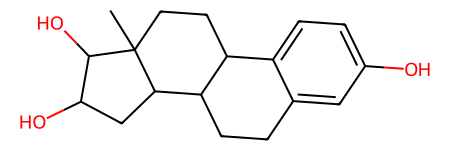

In [7]:
Chem.MolFromSmiles(valid_dataset_ECFP.ids[0])

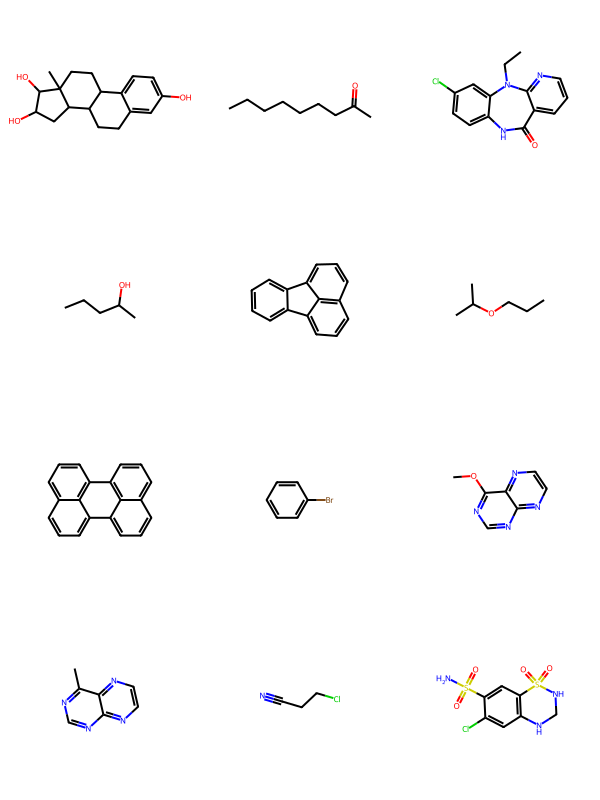

In [8]:
SMILES_strings = valid_dataset_ECFP.ids[:12]
# and this draws a nice image of the 12 molecules
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings]
Draw.MolsToGridImage(ms)

 Now lets look at what the featurised version of that first molecule is:

In [9]:
valid_dataset_ECFP.X[0]

array([0., 0., 0., ..., 0., 0., 0.])

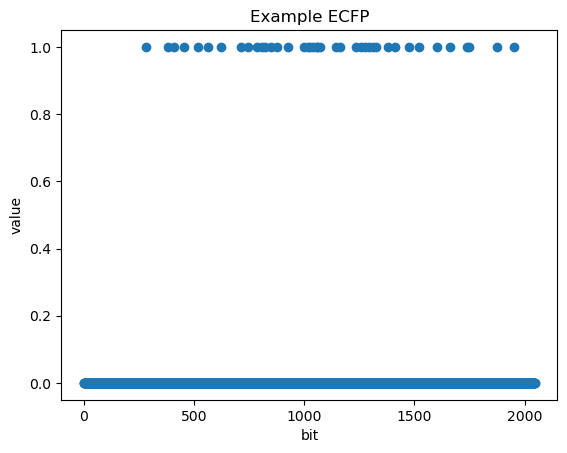

In [10]:
plt.scatter([x for x in range(len(valid_dataset_ECFP.X[0]))], valid_dataset_ECFP.X[0])
plt.xlabel('bit')
plt.ylabel('value')
plt.title('Example ECFP');

ECFP contains only 1s and 0s, it's binary data. Each bit records the presence or abscence of a particular functional group. So we have featurised the SMILES string to a binary code.

In [11]:
len(valid_dataset_ECFP.X[0])

2048

## Example code for task 2: building and training neural networks

As the data is 1D, we can use a standard MultitaskRegressor model to fit it. The example below has two layers of feed-forward NN units, with 500 units in the first layer, and 200 units in the second layer.

`n_tasks`: Num of tasks, i.e. width of y

`n_features` number of features, i.e. width of X

`layer_sizes` how many layers and how many units in each layer to have.

`weight_init_stddevs` initial weights of the units need to be non-zero and different for each unit. They're initialised randomly. This is the standard deviation of the random distribution.

`bias_init_consts=1.0` initial bias value for each unit. (You can do this randomly, but they've chosen not to here)

`dropouts` dropout can help training, this is the value for each layer

`activation_fns` activation functions. 'relu' train fastest. 'sigmoid' is slower

`learning_rate` how quickly our model learns

`batch_size`, size of batch fed to model

In [7]:
# this code makes a nice model
model_ECFP = dc.models.MultitaskRegressor(
    n_tasks = len(tasks), # Num of tasks, i.e. width of y
    n_features=2048, # number of features, i.e. width of X
    layer_sizes=[500, 200], # how many layers and how many units in each layer to have.
    weight_init_stddevs=0.02, 
    bias_init_consts=1.0,
    dropouts=[0.5, 0.0],
    activation_fns=['relu', 'relu'],
    learning_rate=0.01,
    batch_size=100)

Most NN tutorials will get you to train for a certain number of epochs (`nb_epochs`) but in the real world you want to stop training when the **validation** dataset no longer improves. Why? The training dataset can be improved *ad infinitum*, but this is accheived by **over training** so we stop before this happens. The validation dataset is data that is not used to train the NN, but is used to test the model each epoch to see if the model is still training (validation score improves) or is starting to over-train (validation score stagnates or gets worse). 

The word metric means ruler, as in something we use to measure something. Here we're using 2 metrics, the $R^2$ on the validation datasets and the mean average error (MAE) on the validation dataset.  A callback is a peice of code that reports how well the model is doing. Each batch checks the validation stats. 

Training neural networks is hard and requires lots of energy/power/time, so if this takes a long time on your PC, reduce the nb_epochs as you code the exercise. I would suggest increasing it again and leaving the notebook to run once the code is written to get good answers. 

In [13]:
patience =100
nb_epochs = 100
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric2 = dc.metrics.Metric(dc.metrics.mae_score)
metrics = [metric1, metric2]

callback = dc.models.ValidationCallback(
            valid_dataset_ECFP,
            patience,
            metrics=metrics)

Now, we fit the model to the `train_dataset` for `nb_epochs` with the validation `callback`.

In [14]:
start_time = time.time()  # Record the current time

# fit da model
model_ECFP.fit(
    train_dataset_ECFP, 
    nb_epoch=nb_epochs, 
    callbacks=[callback])

end_time = time.time()  # Record the current time again

elapsed_time_ECFP = end_time - start_time  # Calculate the elapsed time
print(f"Elapsed time: {elapsed_time_ECFP:.2f} seconds")  # Print the elapsed time to two decimal places

Step 100 validation: pearson_r2_score=0.713509 mae_score=0.385326
Step 200 validation: pearson_r2_score=0.700394 mae_score=0.405056
Step 300 validation: pearson_r2_score=0.708836 mae_score=0.403179
Step 400 validation: pearson_r2_score=0.703265 mae_score=0.406158
Step 500 validation: pearson_r2_score=0.696433 mae_score=0.416306
Step 600 validation: pearson_r2_score=0.682679 mae_score=0.443832
Step 700 validation: pearson_r2_score=0.707273 mae_score=0.418415
Step 800 validation: pearson_r2_score=0.651755 mae_score=0.43153
Step 900 validation: pearson_r2_score=0.70512 mae_score=0.399222
Step 1000 validation: pearson_r2_score=0.711875 mae_score=0.410375
Elapsed time: 8.27 seconds


In [15]:
# We now evaluate our fitted model on our training and validation sets
train_scores_ECFP = model_ECFP.evaluate(train_dataset_ECFP, metrics, transformers_ECFP)

valid_scores_ECFP = model_ECFP.evaluate(valid_dataset_ECFP, metrics, transformers_ECFP)

test_scores_ECFP = model_ECFP.evaluate(test_dataset_ECFP, metrics, transformers_ECFP)

print(train_scores_ECFP)
print(valid_scores_ECFP)
print(test_scores_ECFP)

{'pearson_r2_score': 0.9557319375263207, 'mae_score': 0.33922651839675755}
{'pearson_r2_score': 0.711875163258412, 'mae_score': 0.8628048507697078}
{'pearson_r2_score': 0.6136838054309979, 'mae_score': 1.026946883236793}


# Task 1. 

Featurize the Delaney dataset using featurizers in the table above. You will want to read and copy parts of the code blocks below. I've included all the settings for each model, you can play around with them should you wish. You want to look at examples of the featurised code to see how the molecules have been encoded. For the five examples above, there is one featurizer that won't show much, as it is an object, one that requires the use of the plotting code (see below) and the rest are straight-forward to view. 

# Task 2

Train some models. Use the code blocks below to train models and for each featurizer, and record the  𝑅2
  and MAE for the train, validate and test set. Which is the best?